# XG Boost Regressor

## Importing the libraries

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [59]:
# pyspark_df = spark.table("sd_bdc_demo.xgboost_regression.2_salesforce_xgboost_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [60]:
# Load csv file
df = pd.read_csv("2_salesforce_xgboost_updated_data/2_salesforce_xgboost_updated_data.csv")

In [61]:
print(df)

    Sales_Order                 Stage  Amount  Probability    Sales_Person  \
0          5708           Closed Lost  255000           40  Alex Rodriguez   
1          5709       Decision Makers  315000           70   Sarah Johnson   
2          5710  Proposal/Price Quote  275000           65   Michael Chang   
3          5711            Closed Won  135000           68     Emma Wilson   
4          5712    Negotiation/Review  325000           85  David Martinez   
..          ...                   ...     ...          ...             ...   
91         5799   Perception Analysis  475000           25  Alex Rodriguez   
92         5800     Value Proposition  115000           40   Sarah Johnson   
93         5801         Qualification   95000           20   Michael Chang   
94         5802            Closed Won   68000           76     Emma Wilson   
95         5803        Needs Analysis  185000           35  David Martinez   

      Company_Industry              Contact_Title          Type

In [62]:
print(df.shape)

(96, 11)


In [63]:
print(df.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


In [64]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sales_Order       96 non-null     int64 
 1   Stage             96 non-null     object
 2   Amount            96 non-null     int64 
 3   Probability       96 non-null     int64 
 4   Sales_Person      96 non-null     object
 5   Company_Industry  96 non-null     object
 6   Contact_Title     96 non-null     object
 7   Type              96 non-null     object
 8   Lead_Source       96 non-null     object
 9   State             96 non-null     object
 10  days_to_close     96 non-null     int64 
dtypes: int64(4), object(7)
memory usage: 8.4+ KB
None


## Encoding categorical data

### Encoding the Independent Variable

In [65]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_cols = [
    'Sales_Person',
    'Company_Industry',
    'Contact_Title',
    'Type',
    'Lead_Source',
    'State'
]

# Save encoder for later use
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  


In [66]:
print(df_encoded.head())

   Sales_Order                 Stage  Amount  Probability  Sales_Person  \
0         5708           Closed Lost  255000           40             0   
1         5709       Decision Makers  315000           70             4   
2         5710  Proposal/Price Quote  275000           65             3   
3         5711            Closed Won  135000           68             2   
4         5712    Negotiation/Review  325000           85             1   

   Company_Industry  Contact_Title  Type  Lead_Source  State  days_to_close  
0                12             29     0            5     42             45  
1                11             20     0           14     23             97  
2                 8              8     0            6     39            117  
3                19             28     0           16     31             36  
4                15             41     0           10     29             92  


In [67]:
print(df_encoded.shape)

(96, 11)


In [68]:
print(df_encoded.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


## Split two Data Frame for Independent Features & Dependent Columns

In [69]:
df_independent = df_encoded.drop(columns=['Probability'])
X = df_independent
df_dependent = df_encoded[['Probability']]
y = df_dependent

In [70]:
print(df_independent.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
0         5708           Closed Lost  255000             0                12   
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
3         5711            Closed Won  135000             2                19   
4         5712    Negotiation/Review  325000             1                15   

   Contact_Title  Type  Lead_Source  State  days_to_close  
0             29     0            5     42             45  
1             20     0           14     23             97  
2              8     0            6     39            117  
3             28     0           16     31             36  
4             41     0           10     29             92  


In [71]:
print(df_independent.shape)

(96, 10)


In [72]:
print(df_dependent.head())

   Probability
0           40
1           70
2           65
3           68
4           85


In [73]:
print(df_dependent.shape)

(96, 1)


## Splitting the dataset into the Training set and Test set (`Closed Won` & `Closed Lost` = `train`)

In [74]:
# Define which rows go into train and test based on 'Stage'
is_train = df_encoded['Stage'].isin(['Closed Won', 'Closed Lost'])

# Split X
X_train = X[is_train] 
X_test = X[~is_train]

# Split y
y_train = y[is_train]
y_test = y[~is_train]  


In [75]:
print(X_train.head())

    Sales_Order        Stage  Amount  Sales_Person  Company_Industry  \
0          5708  Closed Lost  255000             0                12   
3          5711   Closed Won  135000             2                19   
8          5716   Closed Won  235000             2                12   
12         5720   Closed Won  225000             2                 8   
17         5725   Closed Won  175000             2                12   

    Contact_Title  Type  Lead_Source  State  days_to_close  
0              29     0            5     42             45  
3              28     0           16     31             36  
8               4     2            5     38             36  
12             11     2            4     24             38  
17             48     2            5     21             40  


In [76]:
print(X_train.shape)

(25, 10)


In [77]:
print(X_test.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
4         5712    Negotiation/Review  325000             1                15   
5         5713   Perception Analysis  345000             0                23   
6         5714     Value Proposition  195000             4                 6   

   Contact_Title  Type  Lead_Source  State  days_to_close  
1             20     0           14     23             97  
2              8     0            6     39            117  
4             41     0           10     29             92  
5             32     0           14     33            204  
6             20     0            2     41            158  


In [78]:
print(X_test.shape)

(71, 10)


In [79]:
print(y_train.head())

    Probability
0            40
3            68
8            48
12           71
17           75


In [80]:
print(y_train.shape)

(25, 1)


In [81]:
print(y_test.head())

   Probability
1           70
2           65
4           85
5           20
6           45


In [82]:
print(y_test.shape)

(71, 1)


## Feature Scaling
- As this is a tree based model, no need to do feature scaling

## Removing `Sales_Order` & `Stage` in `X_train` & `X_test`

In [83]:
X_train_new = X_train.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [84]:
print(X_train_new.head())

    Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
0   255000                12             29     0            5     42   
3   135000                19             28     0           16     31   
8   235000                12              4     2            5     38   
12  225000                 8             11     2            4     24   
17  175000                12             48     2            5     21   

    days_to_close  
0              45  
3              36  
8              36  
12             38  
17             40  


In [85]:
print(X_train_new.shape)

(25, 7)


In [86]:
X_test_new = X_test.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [87]:
print(X_test_new.head())

   Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
1  315000                11             20     0           14     23   
2  275000                 8              8     0            6     39   
4  325000                15             41     0           10     29   
5  345000                23             32     0           14     33   
6  195000                 6             20     0            2     41   

   days_to_close  
1             97  
2            117  
4             92  
5            204  
6            158  


In [88]:
print(X_test_new.shape)

(71, 7)


## Training the Model

In [89]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)


### RFE

In [90]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=xgb_model, n_features_to_select=5)
rfe.fit(X_train_new, y_train)

# selected features after RFE
selected_features = X_train_new.columns[rfe.support_]
print(selected_features)

Index(['Amount', 'Contact_Title', 'Lead_Source', 'State', 'days_to_close'], dtype='object')


In [91]:
# take only selected columns for both X_train_new & X_test_new
X_train_new = X_train_new[selected_features]
X_test_new = X_test_new[selected_features]
xgb_model_train = xgb_model.fit(X_train_new, y_train.values.ravel())


## Prediction

In [92]:
y_pred = xgb_model.predict(X_test_new)

In [93]:
print(y_pred)

[60.10178  45.24084  62.573692 61.917397 43.773773 51.811188 60.00916
 59.495705 57.434143 57.766262 61.341858 42.112633 55.045105 41.29852
 63.179432 62.76751  59.936375 55.179184 39.442856 41.36541  58.930256
 57.807373 55.846836 39.53585  61.063652 56.649464 55.470932 40.77672
 59.298393 63.87112  60.462387 61.03985  58.5857   50.52598  59.298393
 62.813305 60.416267 41.57222  61.35524  56.649647 61.35524  59.98184
 40.979206 61.371033 61.284    62.56031  58.437737 58.179264 54.938934
 66.74164  69.54127  57.67813  46.880173 63.179432 40.99742  45.418045
 61.0377   56.63152  60.598457 62.587917 61.240334 61.822655 69.813286
 53.77495  63.82847  59.06632  61.992233 60.766792 62.829597 42.085842
 45.74094 ]


### Saving the output as new table

In [94]:
sales_order = X_test['Sales_Order'].values
stage = X_test['Stage'].values

In [95]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71, 1)
y_pred shape: (71,)


In [96]:
print(y_test)

    Probability
1            70
2            65
4            85
5            20
6            45
..          ...
90           85
91           25
92           40
93           20
95           35

[71 rows x 1 columns]


In [97]:
# Flatten y_test to 1D
y_test = y_test.values.ravel()

In [98]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71,)
y_pred shape: (71,)


In [99]:
print(y_test)

[70 65 85 20 45 25 30 75 60 85 25 40 30 30 70 65 80 20 45 25 35 75 60 90
 20 40 30 35 70 65 80 15 45 25 30 75 60 85 20 40 30 35 70 65 85 15 45 25
 30 30 60 20 80 40 25 15 70 90 65 75 20 35 45 30 70 60 85 25 40 20 35]


In [100]:
print(y_pred)

[60.10178  45.24084  62.573692 61.917397 43.773773 51.811188 60.00916
 59.495705 57.434143 57.766262 61.341858 42.112633 55.045105 41.29852
 63.179432 62.76751  59.936375 55.179184 39.442856 41.36541  58.930256
 57.807373 55.846836 39.53585  61.063652 56.649464 55.470932 40.77672
 59.298393 63.87112  60.462387 61.03985  58.5857   50.52598  59.298393
 62.813305 60.416267 41.57222  61.35524  56.649647 61.35524  59.98184
 40.979206 61.371033 61.284    62.56031  58.437737 58.179264 54.938934
 66.74164  69.54127  57.67813  46.880173 63.179432 40.99742  45.418045
 61.0377   56.63152  60.598457 62.587917 61.240334 61.822655 69.813286
 53.77495  63.82847  59.06632  61.992233 60.766792 62.829597 42.085842
 45.74094 ]


In [101]:
results_df = pd.DataFrame({
    'sales_order': sales_order,
    'stage': stage,
    'Actual': y_test,
    'Predicted': y_pred
})


In [102]:
# Create the folder if it doesn't exist
os.makedirs("3_1_salesforce_xgboost_prediction_data", exist_ok=True)

# Save the Excel file inside the folder
results_df.to_csv("3_1_salesforce_xgboost_prediction_data/3_1_salesforce_xgboost_prediction_data.csv", index=False)


In [103]:
# spark_df = spark.createDataFrame(results_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.3_1_salesforce_xgboost_prediction_data")

## Accuracy

In [104]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print("r2:\n", r2_score(y_test, y_pred))
print("MAE:\n", mean_absolute_error(y_test, y_pred))
print("RMSE:\n", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:\n", mean_absolute_percentage_error(y_test, y_pred))

r2:
 -0.17454230785369873
MAE:
 21.390836715698242
RMSE:
 25.076411545825792
MAPE:
 0.6879292726516724


In [105]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


MAPE: 68.79%
Accuracy: 31.21%


## Applying k-Fold Cross Validation

### Shuffled

In [106]:
from sklearn.model_selection import cross_val_score, KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(xgb_model, X=X_train_new, y=y_train, cv=kf)

In [107]:
print("Cross-Validation Results (Accuracy):")
for i, result in enumerate(cross_val_results, 1):
    print(f"  Fold {i}: {result * 100:.2f}%")

print("Kfold Mean ccuracy: {:.2f} %".format(cross_val_results.mean()*100))
print("Standard Deviation: {:.2f} %".format(cross_val_results.std()*100))

Cross-Validation Results (Accuracy):
  Fold 1: 45.49%
  Fold 2: 6.22%
  Fold 3: 5.94%
  Fold 4: 12.52%
  Fold 5: -340.38%
Kfold Mean ccuracy: -54.04 %
Standard Deviation: 143.91 %


### Unshuffled

In [108]:

accuracies = cross_val_score(estimator = xgb_model, X = X_train_new, y = y_train, cv = 5)
print("Kfold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Kfold Accuracy: -4.94 %
Standard Deviation: 53.10 %


## Feature Importance with `shap`

In [109]:
print(xgb_model_train.feature_importances_)


[0.0883081  0.13987556 0.11383628 0.5073345  0.15064558]


.values =
array([  0.72989714,  -1.1552075 ,  -0.515335  , -16.56973   ,
        -1.106747  ], dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([255000,     29,      5,     42,     45])


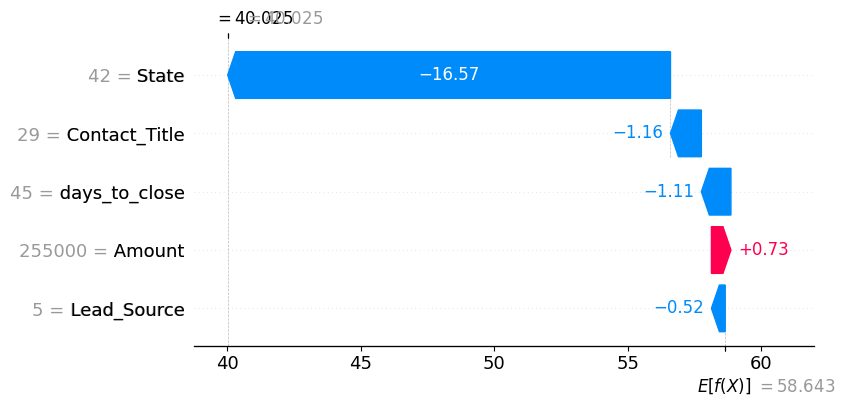

.values =
array([ 0.886989 , -1.0528585,  1.545252 ,  6.631189 ,  1.2683657],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([135000,     28,     16,     31,     36])


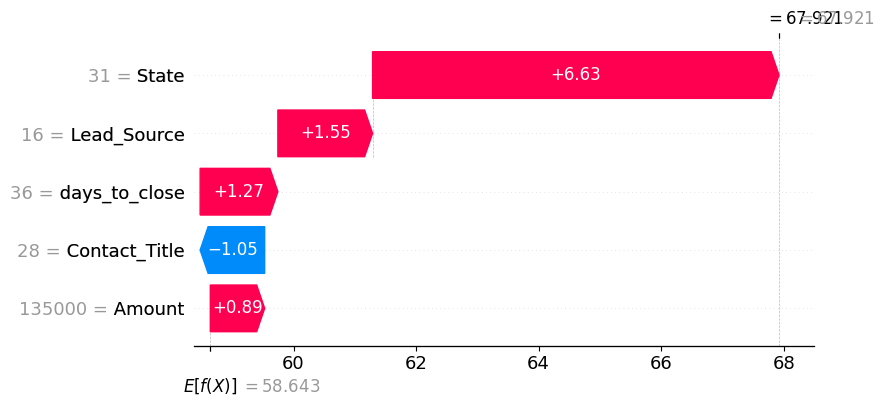

.values =
array([ -0.554109  ,   3.9756565 ,   0.06948137, -14.797369  ,
         0.73366666], dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([235000,      4,      5,     38,     36])


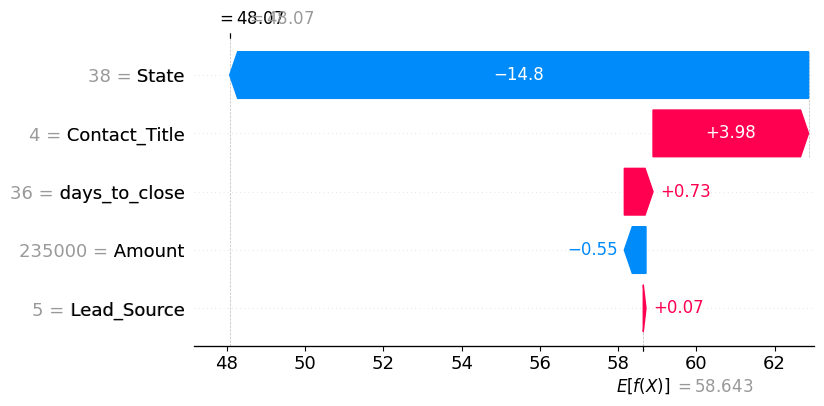

.values =
array([-0.08630066,  4.640868  ,  0.18627726,  6.267001  ,  1.2823253 ],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([225000,     11,      4,     24,     38])


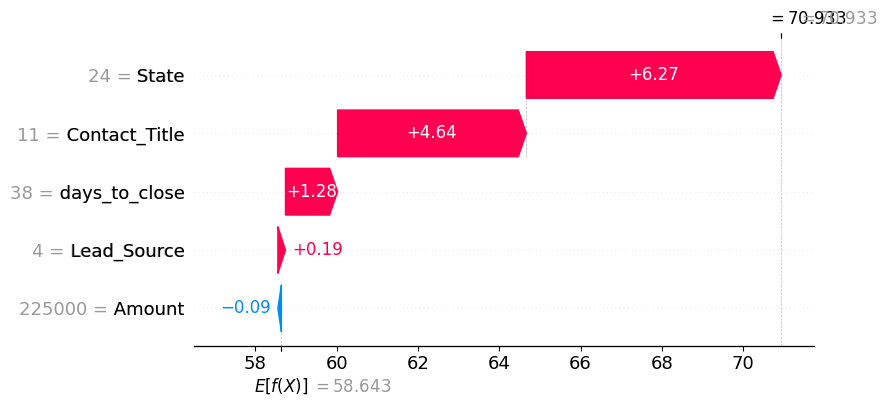

.values =
array([3.5581748, 2.5394382, 1.0554205, 7.2527795, 1.7468117],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([175000,     48,      5,     21,     40])


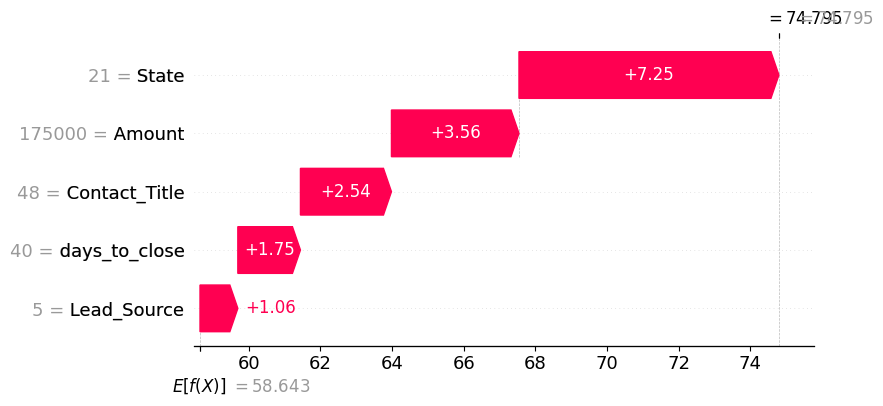

.values =
array([-1.2966151 ,  8.21684   ,  0.8242232 ,  7.1413636 ,  0.48417142],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([85000,    12,    10,    26,    51])


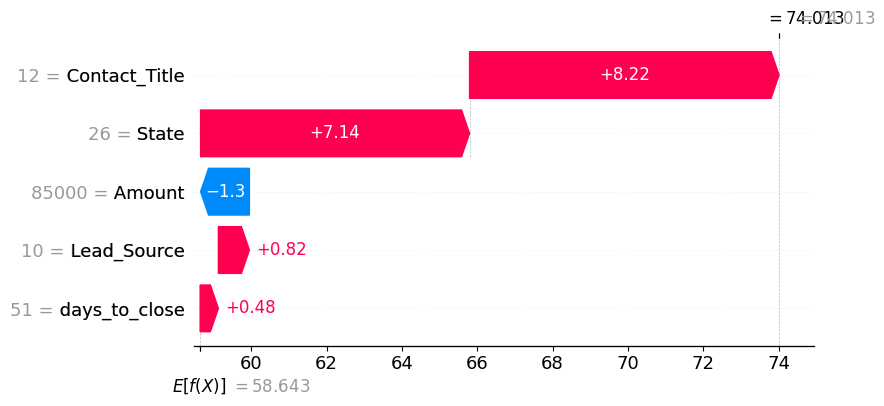

.values =
array([ 6.4207679e-01,  4.0147314e-03,  1.2404478e+00, -1.5392684e+01,
        8.9387858e-01], dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([195000,     49,      4,     42,     36])


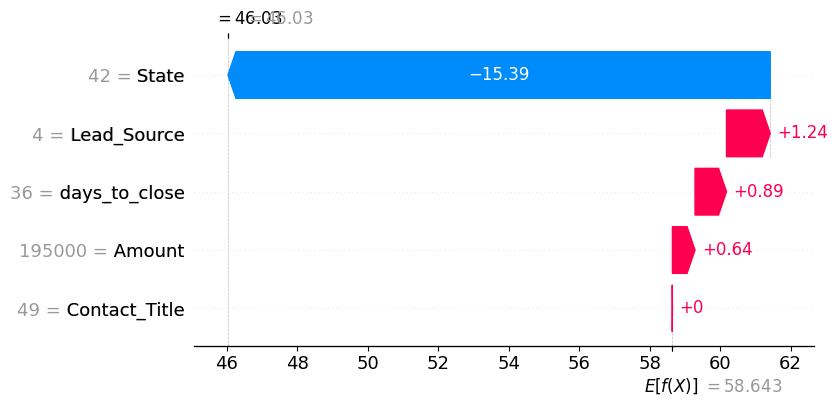

.values =
array([-0.57036906, -5.2775707 , -0.46703318,  3.203757  , -0.20123889],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([145000,     17,      6,     22,     35])


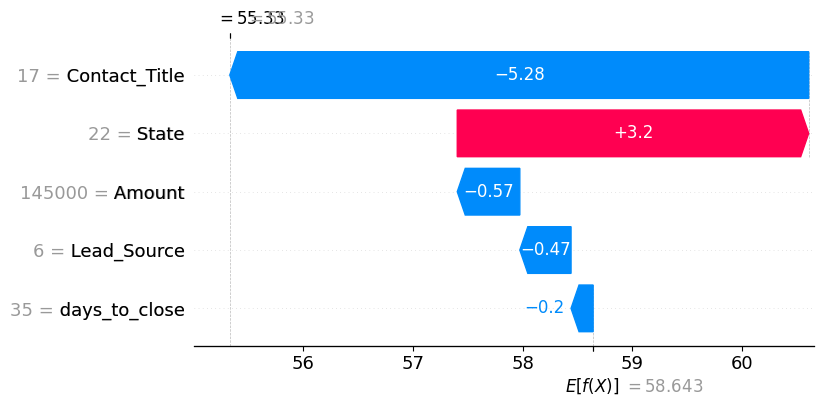

.values =
array([ 2.2073476 , -1.1052513 ,  0.05395189,  6.697637  ,  0.585604  ],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([265000,     31,      4,     26,     56])


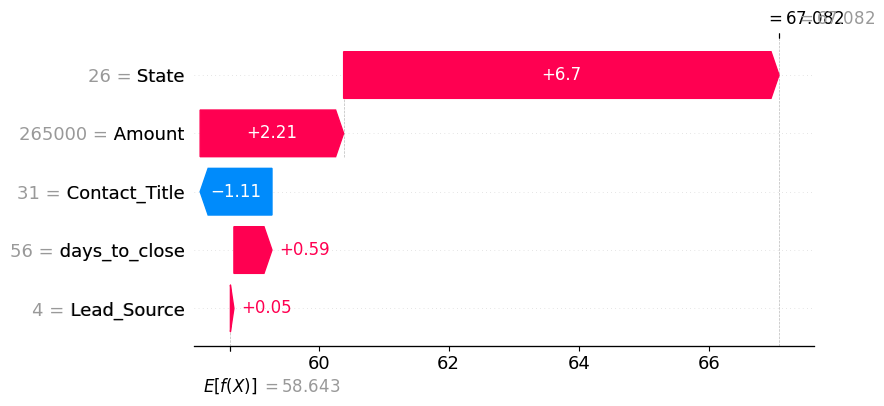

.values =
array([1.4415481 , 1.4725872 , 0.7951917 , 6.705723  , 0.92182696],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([115000,     49,      4,     19,     50])


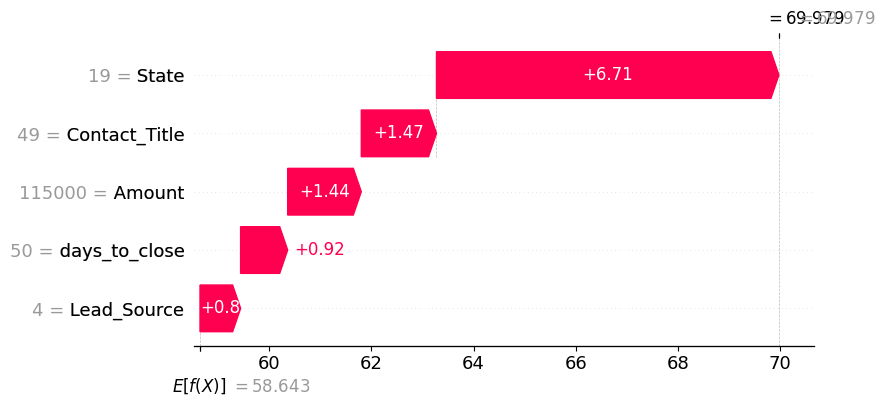

.values =
array([ 2.1807504, -1.0735219,  1.7773525,  4.015419 , -1.5123202],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([295000,     32,     14,      9,     76])


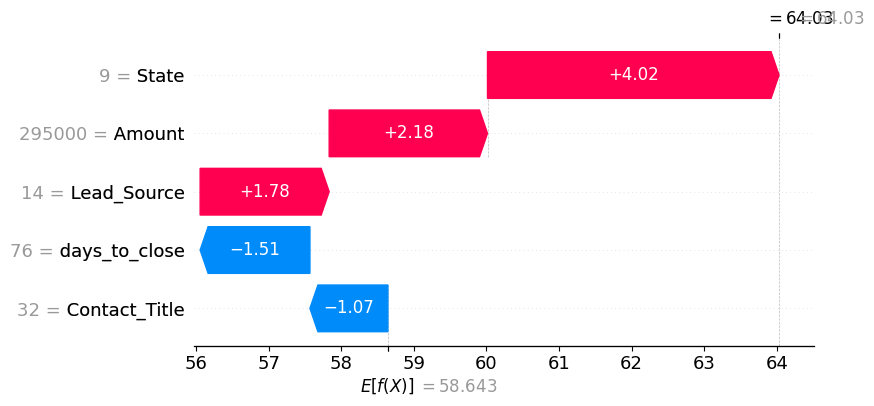

.values =
array([ 0.70118475, -4.731054  , -4.6609    ,  1.7939469 ,  0.18385114],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([145000,     17,      0,     11,     61])


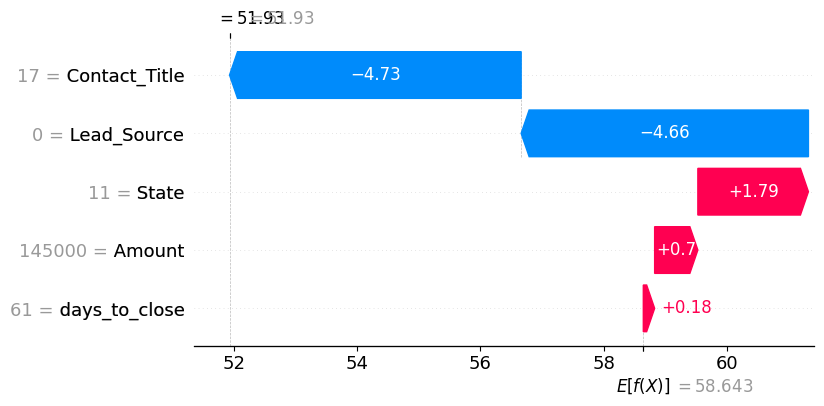

.values =
array([-0.29234377,  9.485595  ,  0.26376572,  6.524181  ,  0.17869009],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([72000,    12,     6,    35,    34])


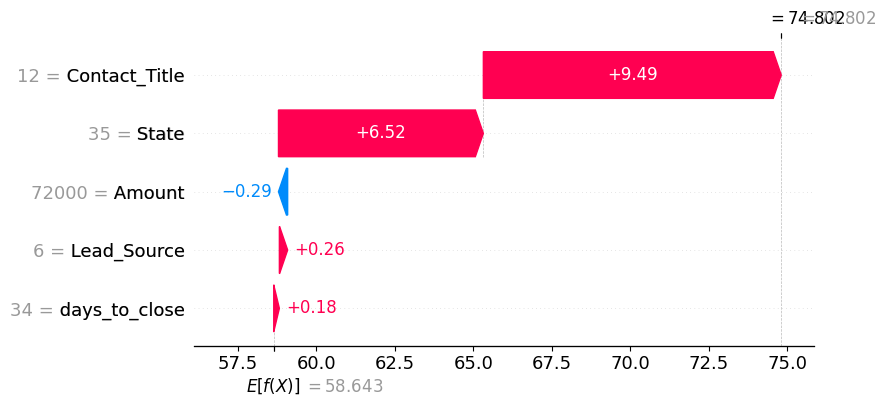

.values =
array([ 0.73619777, -1.3724287 ,  0.5710605 ,  6.43792   ,  0.0905476 ],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([135000,     20,     18,     35,     70])


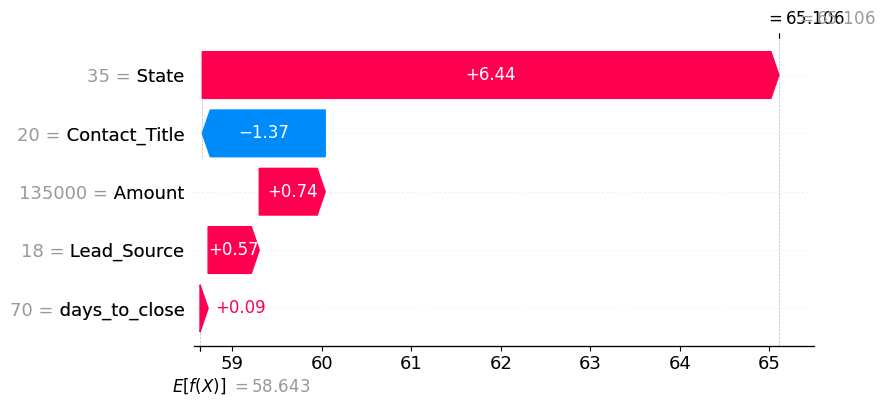

.values =
array([ -1.6317952,  -0.6582649,   1.3223624, -10.073808 ,   2.3660119],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([95000,    44,     4,    41,    44])


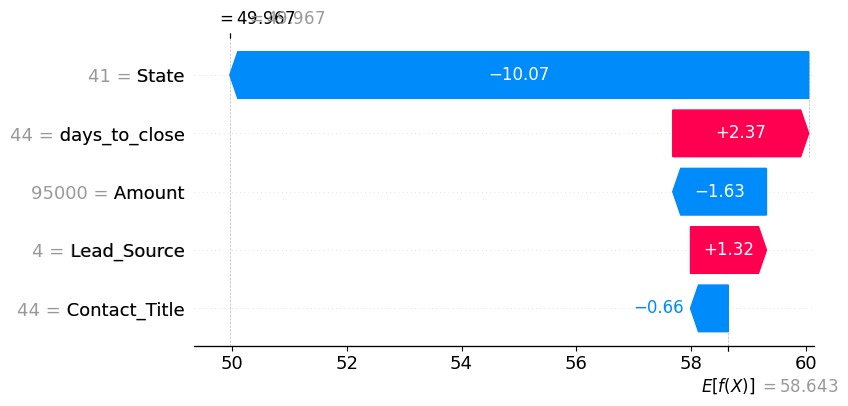

.values =
array([ 1.207575 , -4.1972117,  2.408965 ,  4.320518 ,  0.5231265],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([115000,     17,     15,     10,     35])


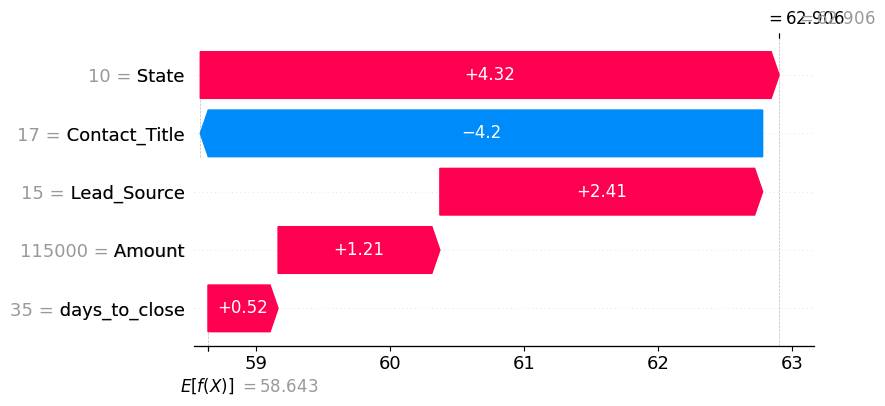

.values =
array([ 3.2781453 , -0.22364952,  1.5889359 ,  7.9702125 ,  0.59946734],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([295000,     19,     14,     32,     71])


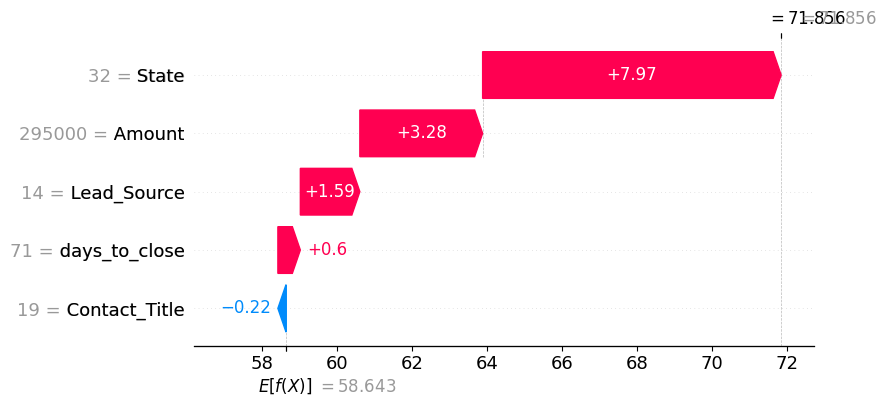

.values =
array([-1.058942  ,  8.547389  ,  1.4266491 ,  3.9925406 ,  0.43185976],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([85000,     3,     4,     0,    34])


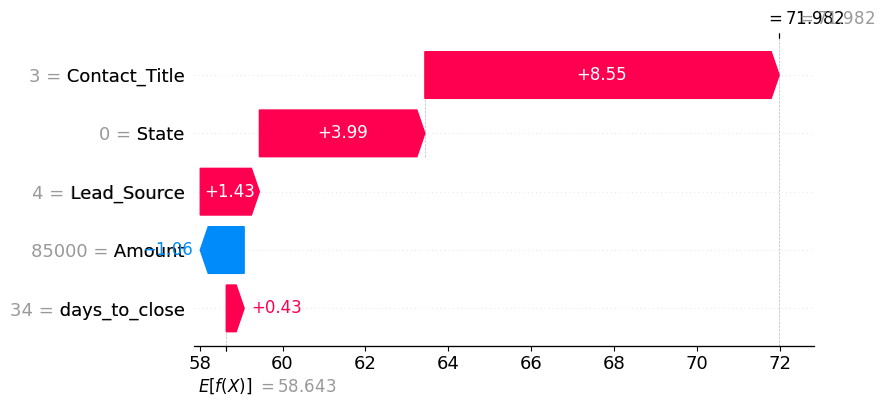

.values =
array([-5.2547445 , -3.3153708 , -2.8449728 ,  0.47262898, -5.614242  ],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([95000,    38,     1,     4,    80])


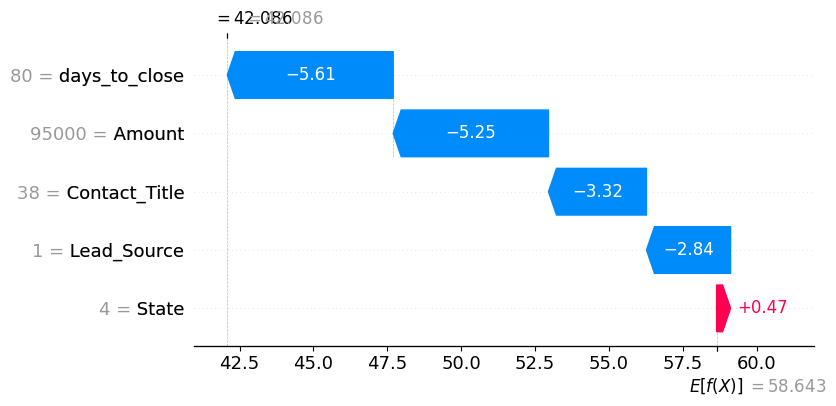

.values =
array([-9.296301  , -3.8428905 , -2.6932032 , -0.8010434 ,  0.05320678],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([42000,    22,     3,    18,    28])


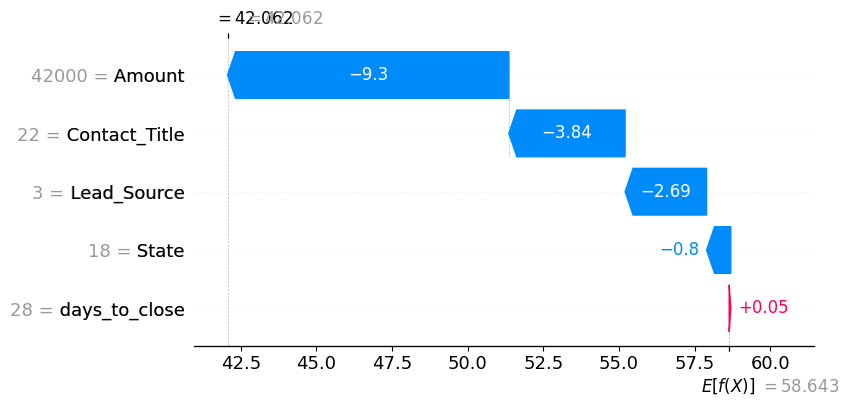

.values =
array([-2.2775843e+00, -3.8050530e+00,  6.0623130e-03, -1.4733483e+01,
       -1.6941597e+00], dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([88000,    57,    14,    43,    66])


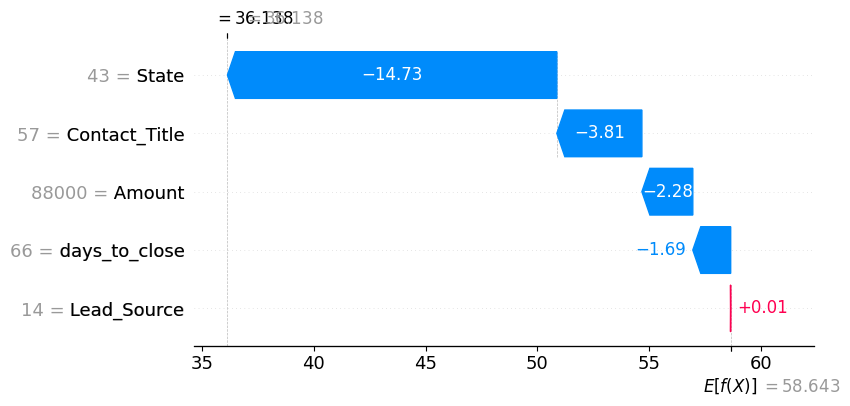

.values =
array([ -1.9168156 ,  -1.6736358 ,  -0.24856536, -12.206182  ,
         0.40570205], dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([65000,    47,    19,    37,    33])


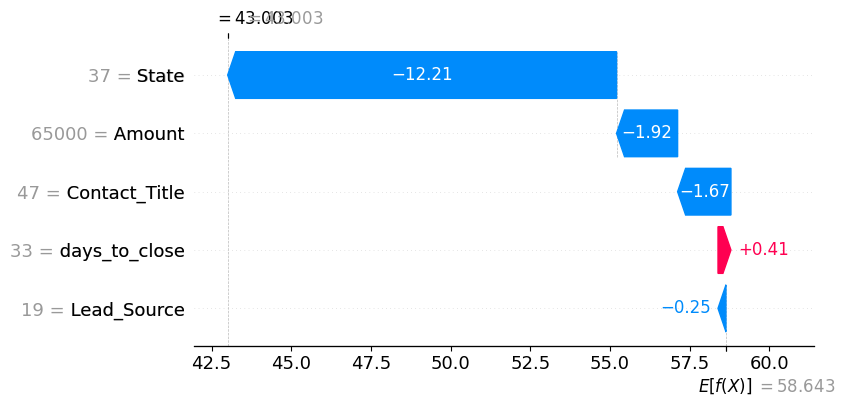

.values =
array([-4.512306  , -3.303913  ,  0.10507298,  4.6603885 , -6.5965986 ],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([78000,    37,     9,    31,    78])


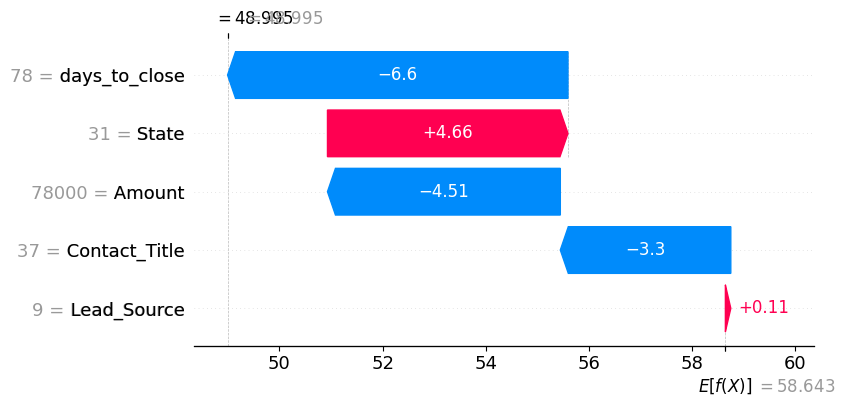

.values =
array([-1.1224757 ,  0.2684537 ,  0.78210574, -8.0899725 ,  0.53662837],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([92000,    14,    15,    44,    35])


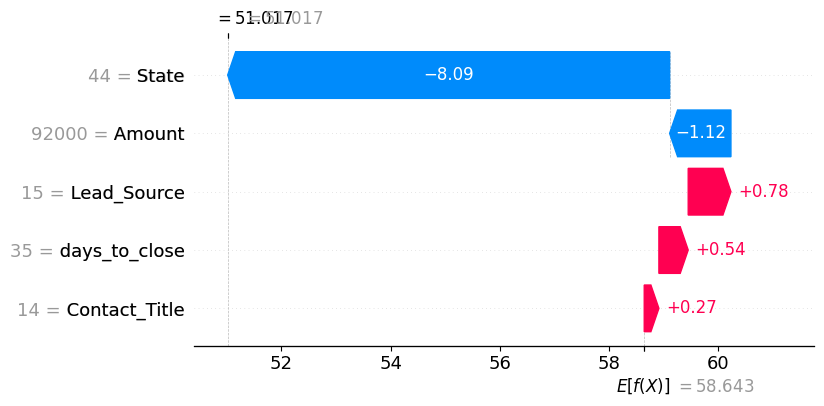

.values =
array([-0.23747045,  9.799671  , -0.3829308 ,  7.6328464 ,  0.5498    ],
      dtype=float32)

.base_values =
np.float32(58.642548)

.data =
array([68000,    13,     1,    30,    56])


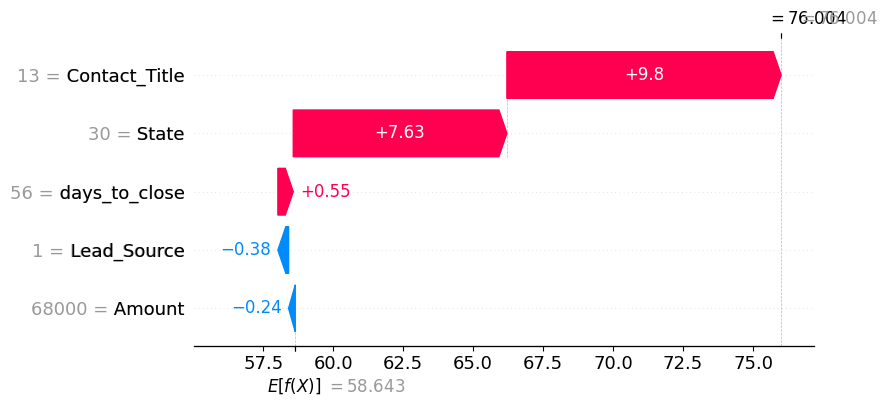

In [110]:
import shap 

explainer = shap.Explainer(xgb_model_train)
shap_values = explainer(X_train_new)
for i in range(0,len(X_train)):
    print(shap_values[i])
    shap.plots.waterfall(shap_values[i])

In [111]:
print(shap_values)

.values =
array([[ 7.2989714e-01, -1.1552075e+00, -5.1533502e-01, -1.6569731e+01,
        -1.1067470e+00],
       [ 8.8698900e-01, -1.0528585e+00,  1.5452520e+00,  6.6311889e+00,
         1.2683657e+00],
       [-5.5410898e-01,  3.9756565e+00,  6.9481365e-02, -1.4797369e+01,
         7.3366666e-01],
       [-8.6300664e-02,  4.6408682e+00,  1.8627726e-01,  6.2670012e+00,
         1.2823253e+00],
       [ 3.5581748e+00,  2.5394382e+00,  1.0554205e+00,  7.2527795e+00,
         1.7468117e+00],
       [-1.2966151e+00,  8.2168398e+00,  8.2422322e-01,  7.1413636e+00,
         4.8417142e-01],
       [ 6.4207679e-01,  4.0147314e-03,  1.2404478e+00, -1.5392684e+01,
         8.9387858e-01],
       [-5.7036906e-01, -5.2775707e+00, -4.6703318e-01,  3.2037570e+00,
        -2.0123889e-01],
       [ 2.2073476e+00, -1.1052513e+00,  5.3951889e-02,  6.6976371e+00,
         5.8560401e-01],
       [ 1.4415481e+00,  1.4725872e+00,  7.9519171e-01,  6.7057228e+00,
         9.2182696e-01],
       [ 2.1807504e+

In [112]:
import pandas as pd
importance_df = pd.DataFrame({
    "Feature": X_train_new.columns,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

print(importance_df)


         Feature  Mean SHAP Value
3          State         7.375372
1  Contact_Title         3.429536
0         Amount         1.907122
4  days_to_close         1.222434
2    Lead_Source         1.113421


### Export Feature Importance

In [113]:
# Create the folder if it doesn't exist
os.makedirs("3_2_salesforce_feature_importance_data", exist_ok=True)

# Save the Excel file inside the folder
importance_df.to_csv("3_2_salesforce_feature_importance_data/3_2_salesforce_feature_importance_data.csv", index=False)


In [114]:
# spark_df = spark.createDataFrame(importance_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.3_2_salesforce_feature_importance_data")